# Evaluation of the model trained for anomaly detection step-by-step

## Import modules

In [1]:
import os, sys
import argparse
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import h5py as h5
import tensorflow as tf
from gwpy.timeseries import TimeSeries
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mean_absolute_error, MeanAbsoluteError, mean_squared_error, MeanSquaredError
from random import sample as RandSample
from sklearn.metrics import auc

sns.set(color_codes=True)

## Define some I/O variables

In [2]:
outdir = './output'        # Required output directory
detector = 'L1'            # LIGO Detector
freq = '2'                 # Sampling frequency of detector in KHz. 2 or 4
filtered = '1'             # Apply LIGO's bandpass and whitening filters. 1/0
timesteps = 100            # Number of timesteps passed to the model
    
# Create output directory
os.system(f'mkdir {outdir}')

# Define frequency in Hz instead of KHz
if int(freq) == 2:
    freq = 2048
elif int(freq) == 4:
    freq = 4096
else:
    print(f'Given frequency {freq}kHz is not supported. Correct values are 2 or 4kHz.')

## Load the dataset

In [3]:
# print(os.getcwd())

load = h5.File('./../dataset/dataset1.hdf', 'r')   # Change this to dataset location!
print('File keys:\n')
print([key for key in load.keys()])

group = load['noise_samples']
print('\n'+'Noise_samples keys:\n')
print([key for key in group.keys()])

dataset = group[f'{str(detector).lower()}_strain'][0:6000]  # I use only one half of the dataset
print('\n'+'L1 strain shape:\n')
print(dataset.shape)

File keys:

['command_line_arguments', 'injection_parameters', 'injection_samples', 'noise_samples', 'normalization_parameters', 'static_arguments']

Noise_samples keys:

['event_time', 'h1_strain', 'l1_strain']

L1 strain shape:

(6000, 16384)


## Select noise samples and injection samples and apply filters and scaler

Define the filtering function (the same used in training)

In [13]:
def filters(array, sample_frequency):
    strain = TimeSeries(array, sample_rate=int(sample_frequency))
    white_data = strain.whiten(fftlength=4, fduration=4)
    bp_data = white_data.bandpass(50, 250)
    return bp_data.value

### Select noise samples

In [14]:
n_noise_events = 2000    # Change according to dataset dim!
noise_samples = load['noise_samples']['%s_strain'%(str(detector).lower())][:][-n_noise_events:]

if bool(int(filtered)):
    print('Filtering data with whitening and bandpass')
    print(f'Sample Frequency: {freq} Hz')
    x_noise = [filters(sample, freq) for sample in noise_samples]
    print('Filtering completed\n')

# Load previous scaler and transform
scaler_filename = f"./output/autoencoder_LSTM/scaler_data_{detector}"    # Change according to scaler location! 
scaler = joblib.load(scaler_filename)
X_train = scaler.transform(x_noise)                   # Input is a list, output is a ndarray!

print("Training data shape:", X_train.shape)

Filtering data with whitening and bandpass
Sample Frequency: 2048 Hz
Filtering completed

Training data shape: (2000, 16384)


### Select injection samples

In [15]:
n_injection_events = 2000
injection_samples = load['injection_samples']['%s_strain'%(str(detector).lower())][:][:n_injection_events]

if bool(int(filtered)):
    print('Filtering data with whitening and bandpass')
    x_injection = [filters(sample, freq) for sample in injection_samples]
    print('Done!\n')
    
# Load previuos scaler and normalize the data
scaler_filename = f"./output/autoencoder_LSTM/scaler_data_{detector}"    # Change according to scaler location! 
scaler = joblib.load(scaler_filename)
X_test = scaler.transform(x_injection)

print("Testing data shape:", X_test.shape)

Filtering data with whitening and bandpass
Done!

Testing data shape: (2000, 16384)


## Define a function to

- Find a threshold for GWs detection
- For each injection event determine whether it is a GW

In [16]:
def TPR_FPR_arrays(noise_array, injection_array, model_outdir, steps, num_entries=400): 
    
    # Load the model
    model = load_model(f'{model_outdir}/best_model.hdf5')
    
    # Trim and reshape the data
    x = []
    for event in range(len(noise_array)): 
        if noise_array[event].shape[0]%steps != 0: 
            x.append(noise_array[event][:-1*int(noise_array[event].shape[0]%steps)])   # Cut-off the tail (the remainder of length/timestep)
    noise_array = np.array(x).reshape(-1, steps, 1)   # num righe = num_event x lughezza eventi senza coda / steps
    print(f'Noise array shape after trimming: {noise_array.shape}')
    
    x = []
    for event in range(len(injection_array)): 
        if injection_array[event].shape[0]%steps != 0: 
            x.append(injection_array[event][:-1*int(injection_array[event].shape[0]%steps)])
    injection_array = np.array(x).reshape(-1, steps, 1)
    print(f'Injection array shape after trimming: {injection_array.shape}')
    
    # Evaluating the model on training data to find threshold 
    print('Evaluating Model on train data. This make take a while...')
    X_pred_noise = model.predict(noise_array)
    print('Finished evaluating model on train data')

    n_noise_events = 2000    # This was 40000 (?). I think it should be the # of samples I have
    
    # Determine thresholds for FPR quantiles
    loss_fn = MeanSquaredError(reduction='none')
    losses = loss_fn(noise_array, X_pred_noise).numpy()   #.eval(session=tf.compat.v1.Session())
    averaged_losses = np.mean(losses, axis=1).reshape(n_noise_events, -1)  # Average loss for each element of noise_array
    max_losses = [np.max(event) for event in averaged_losses]

    roc_steps = num_entries
    FPRs = np.logspace(-4, 0, roc_steps)   # 10^-4 -> 10^0
    thresholds = [np.quantile(max_losses, 1.0-fpr) for fpr in FPRs]  # (1-fpr)th quantile of max_losses 
    
    print('Evaluating Model on test data. This make take a while...')
    X_pred_injection = model.predict(injection_array)
    print('Finished evaluating model on test data')
       
    n_injection_events = 2000  # Same as n_noise_events
    
    losses = loss_fn(injection_array, X_pred_injection).numpy()   #.eval(session=tf.compat.v1.Session())
    averaged_losses = np.mean(losses, axis=1).reshape(n_injection_events, -1)
    
    # For each event determine whether GW was detected at a given FPR threshold
    gw_pred = [[] for i in range(roc_steps)]   #len = #roc_steps, # len of each internal list = # events 
    for i in range(len(averaged_losses)):
        batch_loss = averaged_losses[i]   #rows = #events, #columns = depends on injection array shape
        for fpr in range(len(FPRs)):
            if np.max(batch_loss) > thresholds[fpr]:  #if the max loss for an event exceeds the threshold  
                gw_pred[fpr].append(1)
            else: 
                gw_pred[fpr].append(0)

    # Calculate corresponding TPR
    TPRs = [float(np.sum(gw_pred[fpr]))/n_injection_events for fpr in range(len(FPRs))]
    return(TPRs, FPRs)

## Use the function to test some model

In [17]:
!pwd

directory_list = [f'{outdir}/autoencoder_LSTM']
names = ['autoencoder LSTM']
list_timesteps = [timesteps]    # timestep = [timesteps] diventa una lista annidata

FPR_set = []
TPR_set = []

/home/marcello/PhD_DS/code_tests


In [18]:
print(directory_list)
print(names)
print(list_timesteps)

['./output/autoencoder_LSTM']
['autoencoder LSTM']
[100]


In [19]:
for name, directory, timestep in zip(names, directory_list, list_timesteps):
    print('Determining performance for: %s'%(name))
    TPR, FPR = TPR_FPR_arrays(X_train, X_test, directory, timestep)
    TPR_set.append(TPR)
    FPR_set.append(FPR)
    print('Done!')

Determining performance for: autoencoder LSTM
Noise array shape after trimming: (326000, 100, 1)
Injection array shape after trimming: (326000, 100, 1)
Evaluating Model on train data. This make take a while...
Finished evaluating model on train data
Evaluating Model on test data. This make take a while...
Finished evaluating model on test data
Done!


In [21]:
# print(TPR_set)

## Plot ROC curve and compute AUC

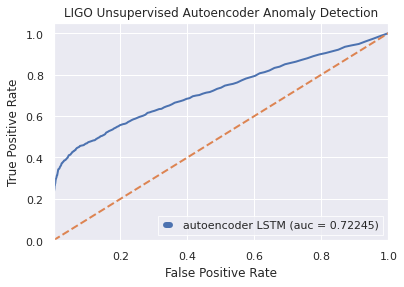

In [25]:
plt.figure()
lw = 2
for FPRs, TPRs, name in zip(FPR_set, TPR_set, names):
    plt.plot(FPRs, TPRs, lw=lw, label='%s (auc = %0.5f)'%(name, auc(FPRs, TPRs)))
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([1e-4, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.xscale('log')
    plt.title('LIGO Unsupervised Autoencoder Anomaly Detection')
    plt.legend(loc="lower right")
    plt.savefig('%s/ROC_curve_log.png'%(outdir))